# Data wrangling com Spark
### Aqui estamos utilizando técnicas de programação imperativa, interagindo com dataframes e suas funções.

In [4]:
# Ocorre um erro no processamento de alguns dados que é devido à variaveis de ambiente
# Execute isso no inicio da aplicação
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable


In [89]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import Window
from pyspark.sql.functions import avg, col, sort_array

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt


In [6]:
spark = SparkSession \
    .builder \
    .master("spark://LAPTOP-GRNB9S39.localdomain:7077") \
    .appName("WranglingData") \
    .enableHiveSupport() \
    .getOrCreate()

23/02/18 14:20:25 WARN Utils: Your hostname, LAPTOP-GRNB9S39 resolves to a loopback address: 127.0.1.1; using 172.24.78.117 instead (on interface eth0)
23/02/18 14:20:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/18 14:20:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
path = 'data/sparkify_log_small.json'
user_log = spark.read.json(path)

In [8]:
user_log.take(2)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000')]

In [9]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
user_log.describe('artist').show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [11]:
user_log.describe('sessionId').show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|             10000|
|   mean|         4436.7511|
| stddev|2043.1281541827561|
|    min|                 9|
|    max|              7144|
+-------+------------------+



In [12]:
user_log.count()

10000

In [13]:
user_log.select("page").show(n=5)

+--------+
|    page|
+--------+
|NextSong|
|NextSong|
|NextSong|
|NextSong|
|    Home|
+--------+
only showing top 5 rows



In [14]:
# mostrando valores unicos
user_log.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [15]:
user_log.select("page").dropDuplicates().sort("page").count()

13

In [16]:
# teste de limpeza automatica
print(f'Inicialmente o df possui {len(user_log.columns)} colunas.')
for u in user_log.columns:
    print(user_log.select(u).dropDuplicates().sort(u).show(n=2))
    if user_log.select(u).dropDuplicates().sort(u).count() < 2 or user_log.select(u).dropDuplicates().sort(u) == None:
        user_cleansed = user_log.drop(u, axis=1)
print(f'Apos limpeza o df possui {len(user_log.columns)} colunas.')

Inicialmente o df possui 18 colunas.
+------+
|artist|
+------+
|  null|
|   !!!|
+------+
only showing top 2 rows

None
+---------+
|     auth|
+---------+
|    Guest|
|Logged In|
+---------+
only showing top 2 rows

None
+---------+
|firstName|
+---------+
|     null|
|   Aakash|
+---------+
only showing top 2 rows

None
+------+
|gender|
+------+
|  null|
|     F|
+------+
only showing top 2 rows

None
+-------------+
|itemInSession|
+-------------+
|            0|
|            1|
+-------------+
only showing top 2 rows

None
+--------+
|lastName|
+--------+
|    null|
| Acevedo|
+--------+
only showing top 2 rows

None
+-------+
| length|
+-------+
|   null|
|1.12281|
+-------+
only showing top 2 rows

None
+-----+
|level|
+-----+
| free|
| paid|
+-----+

None
+------------+
|    location|
+------------+
|        null|
|Aberdeen, WA|
+------------+
only showing top 2 rows

None
+------+
|method|
+------+
|   GET|
|   PUT|
+------+

None
+---------+
|     page|
+---------+
|    Abou

In [17]:
len(user_log.columns)

18

In [18]:
# selecionando determinadas colunas e filtrando os dados
user_log.select(["userId", "firstname", "page", "song"]).where(user_log.userId == "1046").collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

In [19]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

In [20]:
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [21]:
user_log.show(n=5)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|hour|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|       Showaddywaddy|Logged In|  Kenneth|     M|          112| Matthews|232.93342| paid|Charlotte-Concord...|   PUT|NextSong|1509380319284|     5132|Christmas Tears W...|   200|1513720872284|"Mozilla/5.0 (Win...|  1046|  20|
|          Lily Allen|Logged In|Elizabeth|     F|            7|    Chase|195.23873| free|Shrevep

In [22]:
user_log.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='20')

In [23]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [24]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  382|
|   1|  302|
|   2|  352|
|   3|  276|
|   4|  348|
|   5|  358|
|   6|  375|
|   7|  249|
|   8|  216|
|   9|  228|
|  10|  251|
|  11|  339|
|  12|  462|
|  13|  479|
|  14|  484|
|  15|  430|
|  16|  362|
|  17|  295|
|  18|  257|
|  19|  248|
+----+-----+
only showing top 20 rows



In [25]:
songs_in_hour_pd = songs_in_hour.toPandas()

(-1.0, 24.0)

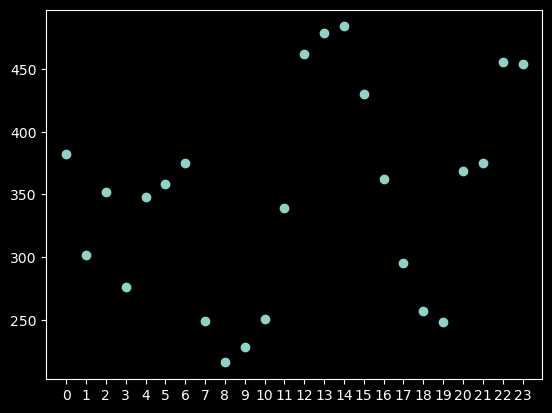

In [26]:
plt.scatter(songs_in_hour_pd['hour'], songs_in_hour_pd['count'])
plt.xlim(-1, 24)

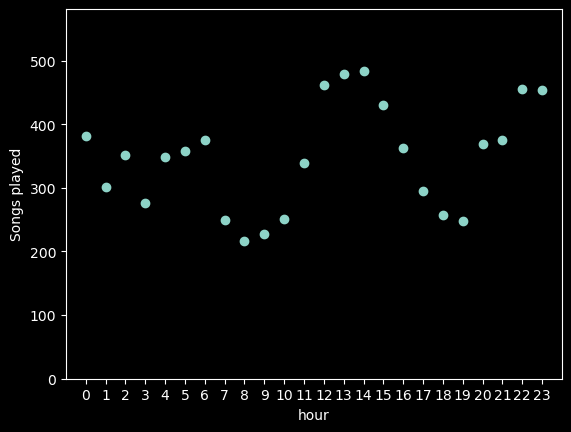

In [28]:
plt.scatter(songs_in_hour_pd['hour'], songs_in_hour_pd['count'])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd['count'] ))
plt.xlabel("hour")
plt.ylabel("Songs played");

In [29]:
user_log_valid = user_log.dropna(how="any", subset=['userId', 'sessionId'])

In [30]:
user_log_valid.count() 

10000

**Acima tentamos dropar as linhas nulas para fazer com q a visualização fique o mais real possivel, entretanto não ocorreu nada. Vamos examinar se realmente não existem valores missing/nulos neste dataset**

In [31]:
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



> Podemos ver que existem valores vazios nesta coluna.

In [32]:
user_log_valid = user_log_valid.filter(user_log_valid['userId'] != '')
user_log_valid.count()

9664

In [33]:
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|   9|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [34]:
user_log.select(['userId', 'firstname', 'page', 'level', 'song']).where(user_log.userId == "1138").collect()

[Row(userId='1138', firstname='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

In [35]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [36]:
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [37]:
user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='20', downgraded=0)

In [39]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [40]:
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [45]:
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(user_log.userId == "1138").sort("ts").collect()

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513731182284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firs

In [50]:
# Which page did user id "" (empty string) NOT visit?
user_log.select(["page"]).where(user_log.userId == "").dropDuplicates().show()

+-----+
| page|
+-----+
| Home|
|About|
|Login|
| Help|
+-----+



In [51]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- hour: string (nullable = true)



In [55]:
# How many female users do we have in the data set?
user_log.select(['gender', 'userId']).dropDuplicates().groupby(user_log.gender).count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  462|
|  null|    1|
|     M|  501|
+------+-----+



In [60]:
# How many songs were played from the most played artist?
user_log.select(['artist', 'song']).groupby(user_log.artist).count().sort(desc('count')).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null| 1653|
|            Coldplay|   83|
|       Kings Of Leon|   69|
|Florence + The Ma...|   52|
|            BjÃÂ¶rk|   46|
|       Dwight Yoakam|   45|
|       Justin Bieber|   43|
|      The Black Keys|   40|
|         OneRepublic|   37|
|        Jack Johnson|   36|
|                Muse|   36|
|           Radiohead|   31|
|        Taylor Swift|   29|
|Barry Tuckwell/Ac...|   28|
|          Lily Allen|   28|
|               Train|   28|
|           Metallica|   27|
|           Daft Punk|   27|
|          Nickelback|   27|
|          Kanye West|   26|
+--------------------+-----+
only showing top 20 rows



In [82]:
# How many songs were played from the most played artist?
df = user_log
df.filter(df.page == 'NextSong') \
    .select('Artist') \
    .groupBy('Artist') \
    .agg({'Artist':'count'}) \
    .withColumnRenamed('count(Artist)', 'Artistcount') \
    .sort(desc('Artistcount')) \
    .show(1)

+--------+-----------+
|  Artist|Artistcount|
+--------+-----------+
|Coldplay|         83|
+--------+-----------+
only showing top 1 row



In [ ]:
user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [67]:
flag_home_event = udf(lambda x: 0 if x == "Home" else 1, IntegerType())
user_log_valid = user_log_valid.withColumn("is_n_home", flag_home_event("page")).orderBy(desc("ts"))

user_log_valid.select(["userId", "firstname", "artist", "song", "ts", "page", "level", "is_n_home"]).where(user_log.userId == "1138").sort("ts").show(n=100)

+------+---------+--------------------+--------------------+-------------+----------------+-----+---------+
|userId|firstname|              artist|                song|           ts|            page|level|is_n_home|
+------+---------+--------------------+--------------------+-------------+----------------+-----+---------+
|  1138|    Kelly|                null|                null|1513729066284|            Home| paid|        0|
|  1138|    Kelly|           Black Box| Everybody Everybody|1513729066284|        NextSong| paid|        1|
|  1138|    Kelly|         Future Rock|               Gears|1513729313284|        NextSong| paid|        1|
|  1138|    Kelly|       Kings Of Leon|        Use Somebody|1513729552284|        NextSong| paid|        1|
|  1138|    Kelly|               Queen|Love Of My Life (...|1513729783284|        NextSong| paid|        1|
|  1138|    Kelly|       Jackie Greene|Down In The Valle...|1513730001284|        NextSong| paid|        1|
|  1138|    Kelly|     The T

In [79]:
user_log_valid.groupBy("userId").sum("is_n_home").alias("temp").show()

+------+--------------+
|userId|sum(is_n_home)|
+------+--------------+
|  2904|             1|
|   691|             3|
|  2294|            57|
|  2162|            37|
|  1436|             2|
|  2088|            13|
|  2275|             4|
|  2756|             6|
|   800|             2|
|  1394|            27|
|   926|             4|
|  1746|             0|
|  2696|             1|
|  1280|             0|
|   870|             2|
|     7|             2|
|  1903|             5|
|   591|             1|
|   613|             3|
|   574|             5|
+------+--------------+
only showing top 20 rows



In [80]:
user_log_valid.groupBy("userId").sum("is_n_home").agg(avg("sum(is_n_home)")).show()

+-------------------+
|avg(sum(is_n_home))|
+-------------------+
|  9.060228452751817|
+-------------------+



In [87]:
# Question 5 (challenge)
# How many songs do users listen to on average between visiting our home page? Please round your answer to the closest integer.
df = user_log_valid
function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

In [90]:
cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(user_window))

cusum.show(n=5)

+------+--------+-------------+---------+------+
|userID|    page|           ts|homevisit|period|
+------+--------+-------------+---------+------+
|    10|NextSong|1513828388284|        0|     0|
|    10|NextSong|1513790894284|        0|     0|
|   100|    Home|1513839673284|        1|     1|
|   100|NextSong|1513776308284|        0|     1|
|   100|    Home|1513776194284|        1|     2|
+------+--------+-------------+---------+------+
only showing top 5 rows



In [91]:
cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

+------------------+
|avg(count(period))|
+------------------+
| 6.898347107438017|
+------------------+

